In [36]:
import torch 
import os
import torch.nn as nn
import seaborn
import koreanize_matplotlib
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator
from bareunpy import Tagger
from konlpy.tag import Mecab

# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = 'cpu'

In [37]:
import string

PUNCTUATION = string.punctuation
PUNCTUATION

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [38]:
ROOT = './DATA/TABLES/'

tables = []
names = os.listdir(ROOT)
for x in names: tables.append(pd.read_csv(ROOT+x, encoding='utf-8'))



In [39]:
### 경상도쪽 표준어 작성된 데이터셋을 활용함


In [40]:
totaldf = []
for idx, table in enumerate(tables):
    tables[idx] = table.melt().reindex(columns=['value', 'variable'])
    tables[idx].reset_index(drop=True, inplace=True)
    mask = tables[idx]['variable'] == '사투리'
    df = tables[idx][mask].copy()
    df['variable'] = names[idx].split('.')[0]
    totaldf.append(df)


totaldf.append(tables[0][tables[0]['variable'] == '표준어'])
totaldf = pd.concat(totaldf, axis=0)
totaldf.reset_index(drop=True, inplace=True)

In [41]:
names


['경상도.csv', '강원도.csv', '전라도.csv', '충청도.csv', '제주도.csv']

In [42]:
# 전지역으로 설정하기
TABLETARGET = totaldf

In [43]:
TABLETARGET.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 677456 entries, 0 to 677455
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   value     677456 non-null  object
 1   variable  677456 non-null  object
dtypes: object(2)
memory usage: 10.3+ MB


In [44]:
TABLETARGET.drop_duplicates(inplace=True)

In [45]:
TABLETARGET.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 473942 entries, 0 to 677454
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   value     473942 non-null  object
 1   variable  473942 non-null  object
dtypes: object(2)
memory usage: 10.8+ MB


In [46]:
# zip_tables = list(zip(tables, names))

class TableDataset(Dataset):
    
    def __init__(self, table):
        super().__init__()
        self.table = table
        self.category = self.table['variable'].astype('category')
        self.label = self.category.cat.codes
        self.catlabel = pd.concat([self.category, self.label], axis=1)

        # print(type(self.label), type(self.table), self.label.shape, self.table.shape)
        
    def __len__(self):
        number = len(self.table)
        return number
    
    def __getitem__(self, idx):
        # 데이터 로드
        label = self.label.iloc[idx]
        sentence = self.table['value'].iloc[idx]
        
        return label, sentence
        
# 토큰화 함수
from jamo import h2j, j2hcj
def tokenize(iterator, tokenizer):
    for label, text in iterator:
        yield tokenizer(text)

def tokenize_baerun(iterator, tokenizer):
    for label, text in iterator:
        yield tokenizer.tags('안녕하세요').morphs()

In [47]:
# split data using train test 
from sklearn.model_selection import train_test_split

train, test = train_test_split(TABLETARGET, test_size=0.2, random_state=42, stratify=TABLETARGET['variable'])

In [48]:

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

train.dropna(inplace=True)
test.dropna(inplace=True)



In [49]:

train['variable'].value_counts(), test['variable'].value_counts()

(전라도    93921
 강원도    76374
 충청도    73307
 경상도    65068
 표준어    53506
 제주도    16977
 Name: variable, dtype: int64,
 전라도    23481
 강원도    19094
 충청도    18327
 경상도    16267
 표준어    13376
 제주도     4244
 Name: variable, dtype: int64)

In [50]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379153 entries, 0 to 379152
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   value     379153 non-null  object
 1   variable  379153 non-null  object
dtypes: object(2)
memory usage: 5.8+ MB


In [51]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379153 entries, 0 to 379152
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   value     379153 non-null  object
 1   variable  379153 non-null  object
dtypes: object(2)
memory usage: 5.8+ MB


In [52]:

# 데이터셋 정의
gyd_train = TableDataset(train)
gyd_test = TableDataset(test)
gyd_total = TableDataset(TABLETARGET)


gyd_test[0]

(4, '그래서 이렇게 같이 맺어서 인저 가운데를 접으면 이게 네 가닥이 되니까 신발 끄트매기를 이렇게 맺어유')

In [53]:
train.shape, gyd_train.__len__(), test.shape

((379153, 2), 379153, (94789, 2))

In [54]:
UNK = '<unk>'
PAD = '<pad>'

# 토큰화 인스턴스 생성 
with open('./hangul_stopword.txt') as f:
    stopwords = f.read().splitlines()

def tokenizer(x):
    result = Mecab().morphs(x)
    for idx, word in enumerate(result):
        for char in word:
            if char in PUNCTUATION:
                result[idx] = result[idx].replace(char, '')
                # print('punc_deleted')
        # if word in stopwords:
        #     result.pop(idx)
            # print('stop_deleted',idx)
    return result


API_KEY = 'koba-TXPHP7A-AOWEX4Y-WCTFG3I-RFAISLA'
tokenizer_baerun = Tagger(API_KEY, '127.0.0.1', 5757)


# tokenizer_baerun = tokenizer_baerun.tags('안녕하세요').morphs()
# tokenizer_baerun

In [55]:
import pickle
VOCAFILE = './vocab_multi.pkl'
if not os.path.exists(VOCAFILE):
    # 단어사전 생성하기 
    vocab = build_vocab_from_iterator(tokenize(gyd_train, tokenizer), specials=[UNK, PAD])
    # vocab = build_vocab_from_iterator(tokenize_baerun(gyd_train, tokenizer_baerun), specials=[UNK, PAD])

    # default unk
    vocab.set_default_index(vocab[UNK])
    with open(VOCAFILE, 'wb') as f:
        pickle.dump(vocab, f)
else:
    with open(VOCAFILE, 'rb') as f:
        vocab = pickle.load(f)
    


In [56]:
vocab(['먹', '것'])

[23, 28]

In [57]:
vocab(['먹', '것', '이', '것'])

[23, 28, 4, 28]

In [58]:
def text_pipeline(x):
    return vocab(tokenizer(x))

# def label_pipeline(x):
#     # 데이터셋에서 라벨을 0부터 잡았으므로 그대로 정수 반환
#     return int(x)

def collate_batch(batch):
    labels, text_list, offsets = [], [], [0]
    
    for label, text in batch:
        
        labels.append(label)
        
        processed_text = torch.tensor(text_pipeline(text), dtype=torch.int64)
        text_list.append(processed_text)
        
        offsets.append(processed_text.size(0))
        
        
    labels = torch.tensor(labels, dtype=torch.int64).to(DEVICE)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0).to(DEVICE)
    text_list = torch.cat(text_list).to(DEVICE)
    
    return labels, text_list, offsets


In [59]:
BATCHSIZE = 10000



trainloader = DataLoader(gyd_train, batch_size=BATCHSIZE, collate_fn=collate_batch, num_workers=64, shuffle=True)
testloader = DataLoader(gyd_test, batch_size=BATCHSIZE, collate_fn=collate_batch, num_workers=64, shuffle=True)


In [60]:
num_Class = len(gyd_train.category.cat.categories)
vocab_size = len(vocab)
embed_dim = 15
hidden_dim = 30


In [61]:
class TextMulti(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_Class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim)
        self.rnn = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, num_Class)
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        
    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        output, _hidden = self.rnn(embedded)
        return self.fc(output)


model = TextMulti(vocab_size, embed_dim, hidden_dim, num_Class).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)




In [62]:
from torchmetrics.classification import MulticlassConfusionMatrix, MulticlassF1Score, MultilabelF1Score, MultilabelConfusionMatrix, MultilabelAccuracy
import numpy as np

def train(model, iterator, optimizer, criterion, scheduler):
    model.train()
    lossagg = []
    f1 = MulticlassF1Score(num_Class).to(DEVICE)
    cm = MulticlassConfusionMatrix(num_Class).to(DEVICE)
    
    
    for label, text, offsets in iterator:
        # label = label.unsqueeze(1)

        # label = F.one_hot(label, num_classes=num_Class).float()

        predictions = model(text, offsets)
        # print(predictions.shape, label.shape)
        loss = criterion(predictions, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        lossagg.append(loss.item())
        f1(predictions, label)
        cm(predictions, label)
        
            
    print(f"Train F1 score : {f1.compute()}")
    print(f"Train Confusion Matrix : \n{cm.compute()}")

    return f1.compute().cpu().item(), np.mean(lossagg)
    
def evaluate(model, iterator, criterion):
    model.eval()
    lossagg = []
    f1 = MulticlassF1Score(num_Class).to(DEVICE)
    cm = MulticlassConfusionMatrix(num_Class).to(DEVICE)
    
    
    with torch.no_grad():
        for label, text, offsets in iterator:
            # label = label.unsqueeze(1)
            
            # label = F.one_hot(label, num_classes=num_Class).float()

            predictions = model(text, offsets)
            loss = criterion(predictions, label)
            
            lossagg.append(loss.item())
            f1(predictions, label)
            cm(predictions, label)
            
    print(f"Test F1 score : {f1.compute()}")
    print(f"Test Confusion Matrix : \n{cm.compute()}")
    
    return f1.compute().cpu().item(), np.mean(lossagg), cm.compute().cpu().numpy()


### 병목 증상 설명

- 기존 이미지의 경우에는 GPU에서 돌리는 것이 효과적
- 하지만 단어 태깅이 CPU 에서 이루어지므로 자연어 처리에서는 CPU가 더 효과적임


In [63]:
EPOCHES = 15
results = [[], []]
latestcm = None
for epoch in range(EPOCHES):
    print(f"Epoch {epoch+1} 학습 및 평가 결과")
    tresult, trainloss = train(model, trainloader, optimizer, criterion, scheduler)
    evalresult, val_loss, latestcm = evaluate(model, testloader, criterion)
    

    results[0].append(tresult)
    results[1].append(evalresult)
    scheduler.step(val_loss)
    

    if scheduler.num_bad_epochs >= scheduler.patience:
        print(f'Early stopping at epoch {epoch}')
        break




Epoch 1 학습 및 평가 결과


Train F1 score : 0.0940486416220665
Train Confusion Matrix : 
tensor([[    0,   139, 57228,     2,     0, 19005],
        [    0,   215, 48493,     8,     0, 16352],
        [    0,   161, 70451,     5,     0, 23304],
        [    0,    57, 12827,     5,     0,  4088],
        [    0,   195, 54879,     9,     0, 18224],
        [    0,   189, 39691,     6,     0, 13620]])
Test F1 score : 0.06617908179759979
Test Confusion Matrix : 
tensor([[    0,     0, 19094,     0,     0,     0],
        [    0,     0, 16267,     0,     0,     0],
        [    0,     0, 23481,     0,     0,     0],
        [    0,     0,  4244,     0,     0,     0],
        [    0,     0, 18327,     0,     0,     0],
        [    0,     0, 13376,     0,     0,     0]])
Epoch 2 학습 및 평가 결과
Train F1 score : 0.06644631922245026
Train Confusion Matrix : 
tensor([[    1,     0, 76373,     0,     0,     0],
        [    1,    25, 64965,     0,    77,     0],
        [    0,     2, 93918,     0,     1,     0],
        [    

In [70]:
torch.save(model, './model_multi.pt')

In [64]:
location = gyd_train.catlabel.drop_duplicates().sort_values(by = [0])['variable'].to_list()
location

['강원도', '경상도', '전라도', '제주도', '충청도', '표준어']

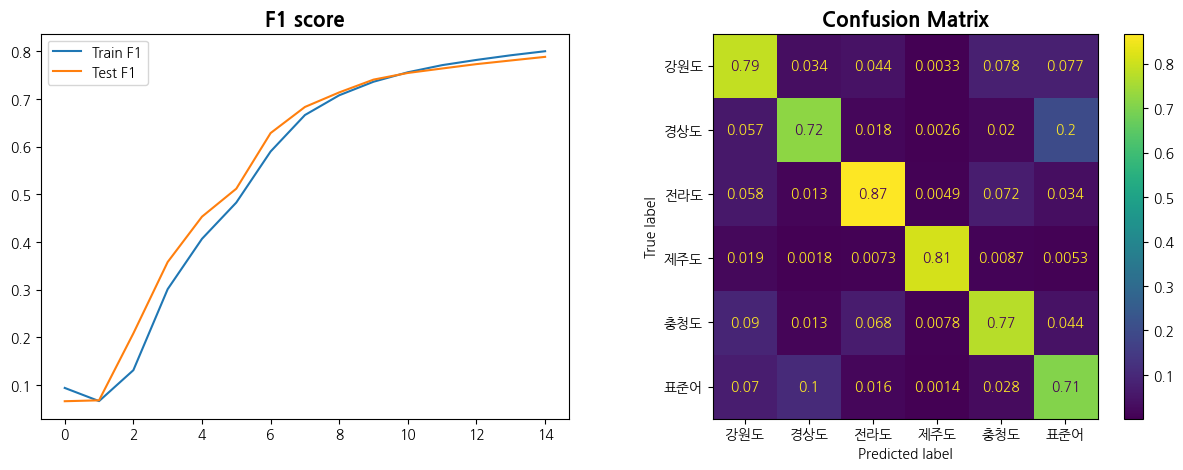

In [69]:
import matplotlib.pyplot as plt
import koreanize_matplotlib
from sklearn.metrics import ConfusionMatrixDisplay

fig, axe = plt.subplots(1, 2, figsize=(15, 5))


titlearg = {
    'fontsize' : 15,
    'fontweight' : 'bold',

}
plt.axes(axe[0])
plt.title('F1 score', **titlearg)
plt.plot(results[0], label='Train F1')
plt.plot(results[1], label='Test F1')
plt.legend()
plt.axes(axe[1])
plt.title('Confusion Matrix', **titlearg)
ConfusionMatrixDisplay(latestcm / latestcm.sum(axis = 1), display_labels=location).plot(ax= axe[1])
plt.show()

In [66]:
# !pip install bareunpy

In [67]:
location

['강원도', '경상도', '전라도', '제주도', '충청도', '표준어']

In [74]:
stdsentence = '한국보건복지인재원은 2004년에 설립돼 국내 보건복지 종사자, 공무원, 사회복무요원 등의 교육을 담당하는 보건의료 대표 교육기관으로 오송에 본원을 비롯해 전국 지역센터 7곳을 운영하며 연간 300만명의 교육을 담당하고 있다.'
dialectsentence = '이제야 호꼼 알아지켜. 나신디는 고장이 호나 이신디…… 그 고장이 나를 질들인 거 닮은게…… 허고 왕자가 고랐다'

softmax = torch.softmax
std = model(torch.tensor(vocab(tokenizer(stdsentence))), torch.tensor([0]))
dialect = model(torch.tensor(vocab(tokenizer(dialectsentence))), torch.tensor([0]))
# std = softmax(std)
# dialect = softmax(dialect)

stdloc = std.argmax().detach().numpy()
dialectloc = dialect.argmax().detach().numpy()
print(softmax(std, dim=1))

print(f"std : {std}, dialect : {dialect}")
print(f"std : {location[stdloc]}, dialect : {location[dialectloc]}")
print(f'std : {stdsentence}, dialect : {dialectsentence}')



tensor([[0.0723, 0.4109, 0.0378, 0.0219, 0.0449, 0.4124]],
       grad_fn=<SoftmaxBackward0>)
std : tensor([[-0.0309,  1.7069, -0.6800, -1.2261, -0.5079,  1.7105]],
       grad_fn=<AddmmBackward0>), dialect : tensor([[ 0.5454, -1.1810,  0.2735,  1.7223, -0.2544, -0.9329]],
       grad_fn=<AddmmBackward0>)
std : 표준어, dialect : 제주도
std : 한국보건복지인재원은 2004년에 설립돼 국내 보건복지 종사자, 공무원, 사회복무요원 등의 교육을 담당하는 보건의료 대표 교육기관으로 오송에 본원을 비롯해 전국 지역센터 7곳을 운영하며 연간 300만명의 교육을 담당하고 있다., dialect : 이제야 호꼼 알아지켜. 나신디는 고장이 호나 이신디…… 그 고장이 나를 질들인 거 닮은게…… 허고 왕자가 고랐다


In [ ]:
location

['강원도', '경상도', '전라도', '제주도', '충청도', '표준어']